## 한글 폰트 설치
https://teddylee777.github.io/colab/colab-korean/


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter    # 배열에서 각 원소 몇번 나오는지 알려줌
import ast
from matplotlib import rc 

# truncation 없이 출력
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')

<ipython-input-2-0c79f28ff0d4>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
pip install koreanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import koreanize_matplotlib

## csv 파일 관리

In [5]:
기타 = pd.read_csv('기타_tokenized.csv', encoding = 'utf-8')
GHB = pd.read_csv('GHB_tokenized.csv', encoding = 'utf-8')
LSD = pd.read_csv('LSD_tokenized.csv', encoding = 'utf-8')
MDMA = pd.read_csv('MDMA_tokenized.csv', encoding = 'utf-8')
대마 = pd.read_csv('대마_tokenized.csv', encoding = 'utf-8')
메스암페타민 = pd.read_csv('메스암페타민_tokenized.csv', encoding = 'utf-8')
사일로시빈 = pd.read_csv('사일로시빈_tokenized.csv', encoding = 'utf-8')
아편 = pd.read_csv('아편_tokenized.csv', encoding = 'utf-8')
알킬니트라이트 = pd.read_csv('알킬니트라이트_tokenized.csv', encoding = 'utf-8')
케타민 = pd.read_csv('케타민_tokenized.csv', encoding = 'utf-8')
코카인 = pd.read_csv('코카인_tokenized.csv', encoding = 'utf-8')

In [6]:
df = pd.concat([GHB, LSD, MDMA, 기타, 대마, 메스암페타민, 사일로시빈, 아편, 알킬니트라이트, 케타민, 코카인], ignore_index=True)

## mecab 토큰화 형태 수정 
- 품사 태깅 (문자열, 문자열) 형태 -> (문자열, 품사 태깅) 형태로 변환 (eval)

In [7]:
for i in range(len(df['mecab'])):
  df['mecab'].loc[i] = eval(df['mecab'].loc[i])

<ipython-input-7-642702a6bb42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mecab'].loc[i] = eval(df['mecab'].loc[i])


## Word2Vec

### 명사, 외국어 토큰 추출

In [8]:
#NNP, SL, NNG 일반, 고유, 외국어

In [9]:
total = []
for idx in range(len(df['mecab'])):
  word = []
  for i, j in df['mecab'].loc[idx]:
    if j == "NNP" or j == "SL" or j == "NNG":
      word.append(i)
  total.append(word)

In [10]:
df = df.assign(word = total)

In [11]:
corpus = []
for i in df['word']:
  corpus.append(i)

In [12]:
corpus_total = []
for i in df['word']:
  for j in i:
    corpus_total.append(j)

In [13]:
from gensim.models import Word2Vec
model = Word2Vec(corpus, vector_size=100, window = 4, min_count = 1, workers = 4, sg = 1)

In [14]:
model_result = model.wv.most_similar('작대기')
print(model_result)

[('아이스', 0.91676265001297), ('술', 0.815900444984436), ('술사', 0.8005585670471191), ('김치', 0.7985113859176636), ('캔디', 0.7891363501548767), ('술파', 0.7854408621788025), ('천안', 0.7806016802787781), ('소개', 0.7801651954650879), ('사용법', 0.7781122326850891), ('마약상', 0.7746843695640564)]


## PCA 주성분 분석

In [15]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors

vectors = model.wv.vectors
words = list(model.wv.key_to_index.keys())
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_complet =PCA_final[['word','x_values','y_values']]

In [16]:
print(PCA_data_complet)

     word  x_values  y_values
0     아이스  2.592849 -0.337148
1     작대기  2.470346 -0.225345
2     텔레   2.136183 -0.434445
3     곳    2.662832 -0.581335
4     술    2.213675 -0.457150
...  ..         ...       ...
7557  보쌈  -0.172366  0.026384
7558  쥬드  -0.155110 -0.012909
7559  비프  -0.124180 -0.078239
7560  쇠고기 -0.188852 -0.037032
7561  항구  -0.164919 -0.072522

[7562 rows x 3 columns]


## Kmeans Clustering

### 최적의 k 값 찾기
- PCA 분석 결과 x_values, y_values 기준

In [17]:
from sklearn.cluster import KMeans

x = []   # k 가 몇개인지 
y = []   # 응집도가 몇인지 

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(PCA_result.iloc[0:,:2])
    
    x.append(k)
    y.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

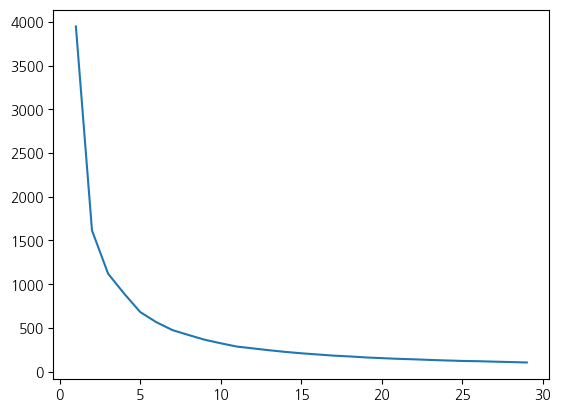

In [18]:
plt.plot(x, y)

In [19]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(PCA_result.iloc[0:,:2])
PCA_data_complet['labels'] = kmeans.predict(PCA_result.iloc[0:,:2])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-3efdbcfd8923>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_data_complet['labels'] = kmeans.predict(PCA_result.iloc[0:,:2])


In [20]:
# 단어 빈도 수 열 추가
PCA_data_complet['counts'] = 0

for i, word in enumerate(PCA_data_complet['word']):  
  PCA_data_complet['counts'][i] = corpus_total.count(word)

<ipython-input-20-af7c61563b2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_data_complet['counts'] = 0
<ipython-input-20-af7c61563b2d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_data_complet['counts'][i] = corpus_total.count(word)


In [21]:
PCA_data_complet

,word,x_values,y_values,labels,counts
0,아이스,2.592849,-0.337148,3,84533
1,작대기,2.470346,-0.225345,3,53881
2,텔레,2.136183,-0.434445,3,21770
3,곳,2.662832,-0.581335,3,16428
4,술,2.213675,-0.457150,3,15149
...,...,...,...,...,...
7557,보쌈,-0.172366,0.026384,4,1
7558,쥬드,-0.155110,-0.012909,4,1
7559,비프,-0.124180,-0.078239,4,1
7560,쇠고기,-0.188852,-0.037032,4,1


## Matplotlib 시각화

### 버전1: 전체 단어 & 전체 텍스트

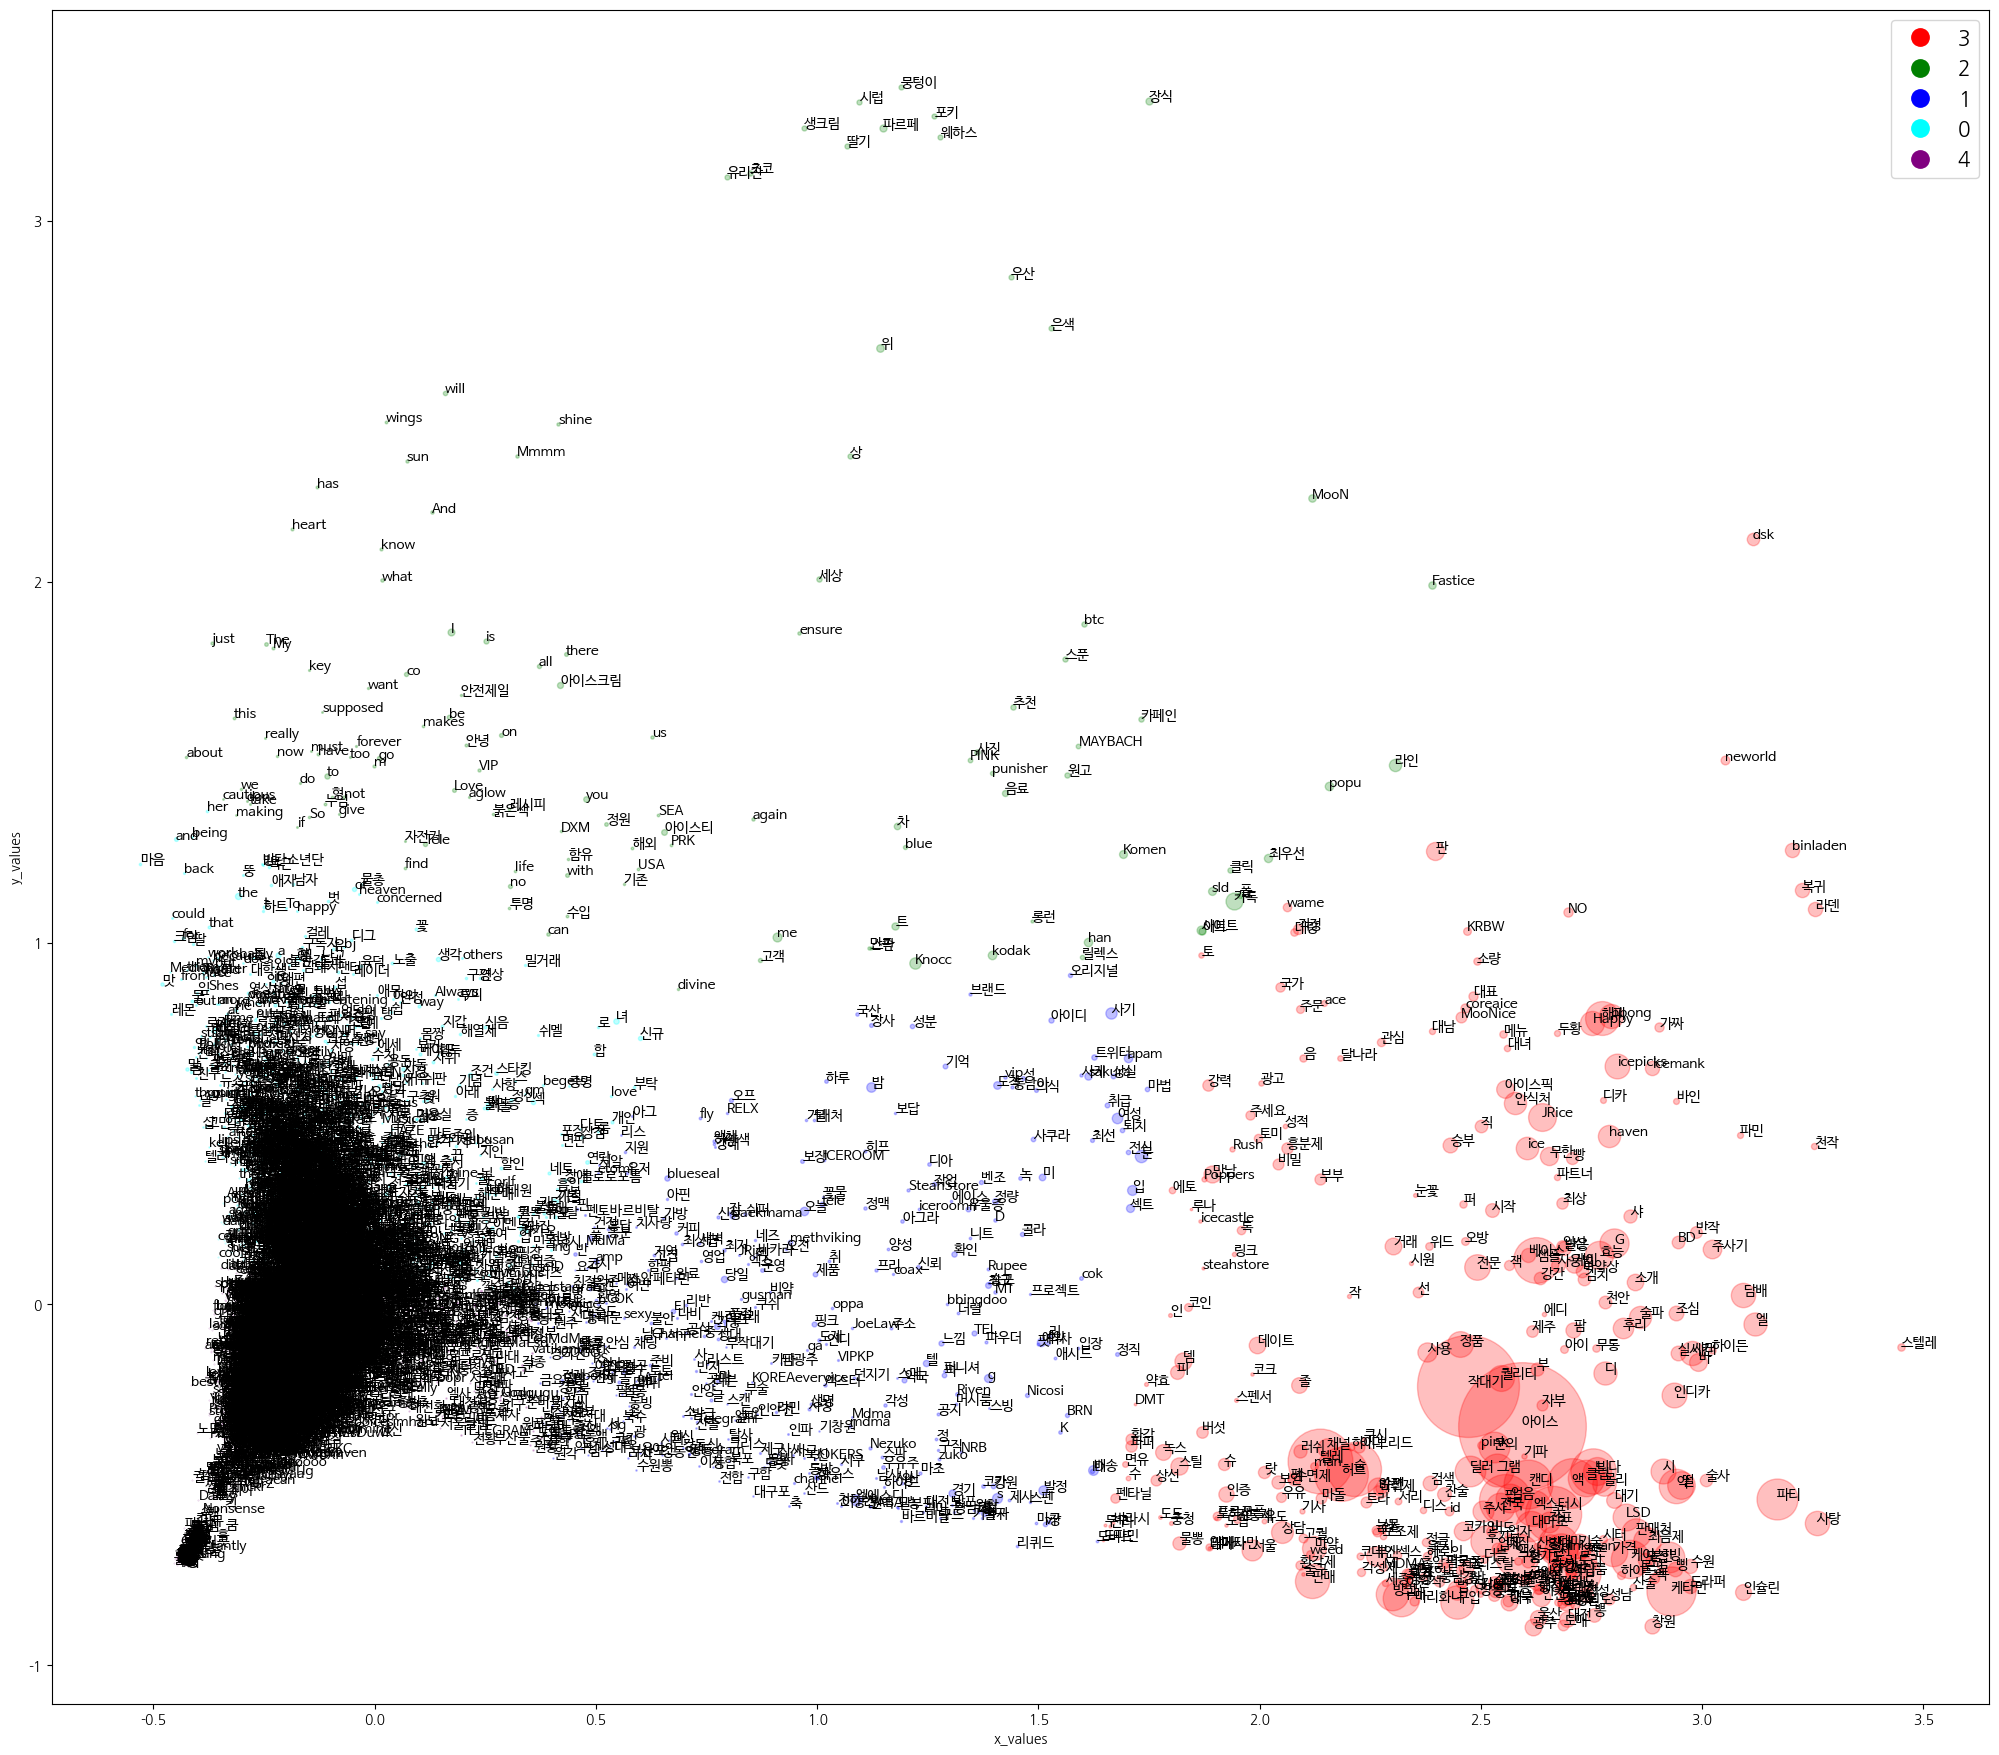

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet.x_values[i], PCA_data_complet.y_values[i], s=PCA_data_complet.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

#[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows() if row.labels == PCA_data_complet.labels[0]]
[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows()]
plt.show()

### 버전2: 전체 단어 & 마약 군집 텍스트만

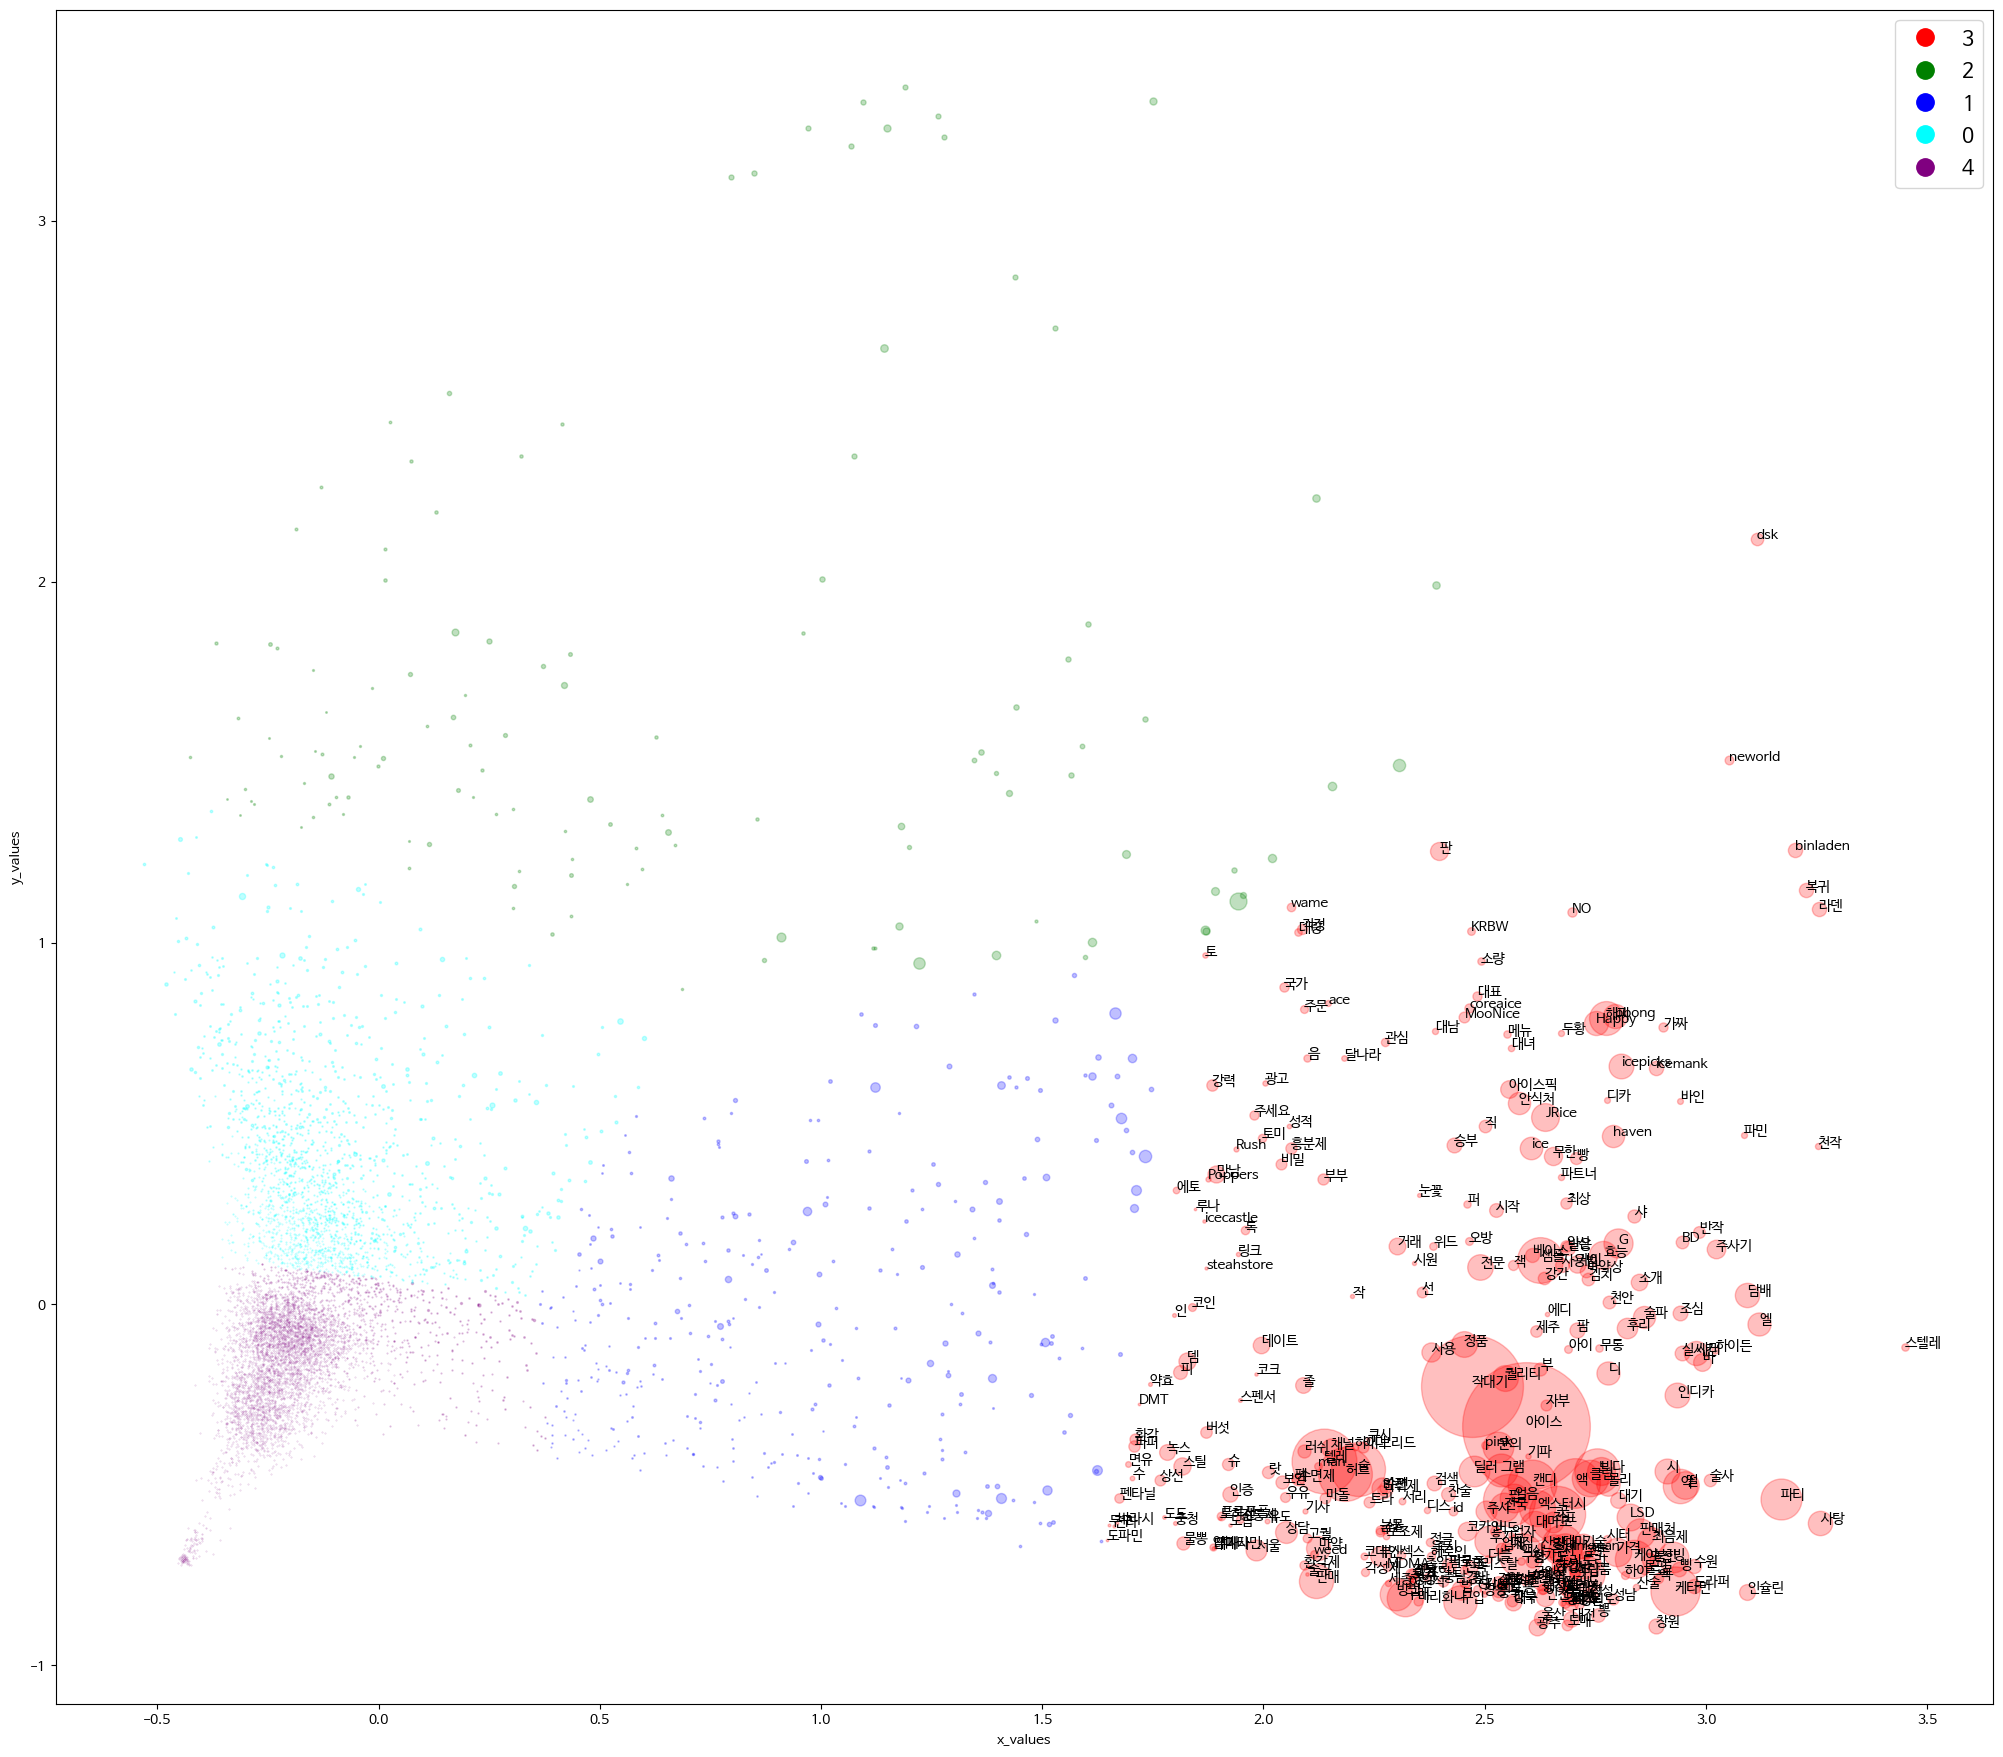

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet.x_values[i], PCA_data_complet.y_values[i], s=PCA_data_complet.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows() if row.labels == PCA_data_complet.labels[0]]
plt.show()

### 버전3: 일부 단어

In [23]:
PCA_data_complet[PCA_data_complet['counts'] >= 2]

,word,x_values,y_values,labels,counts
0,아이스,2.592849,-0.337148,3,84533
1,작대기,2.470346,-0.225345,3,53881
2,텔레,2.136183,-0.434445,3,21770
3,곳,2.662832,-0.581335,3,16428
4,술,2.213675,-0.457150,3,15149
...,...,...,...,...,...
3781,retreated,-0.345088,0.031339,4,2
3782,정력,-0.168171,0.030318,4,2
3783,앰,-0.124152,0.051826,4,2
3784,목동,-0.137021,0.032515,4,2


In [31]:
PCA_data_complet[PCA_data_complet['counts'] >= 2]['labels'].value_counts() 

0    1964
3    1011
4    358 
1    330 
2    123 
Name: labels, dtype: int64

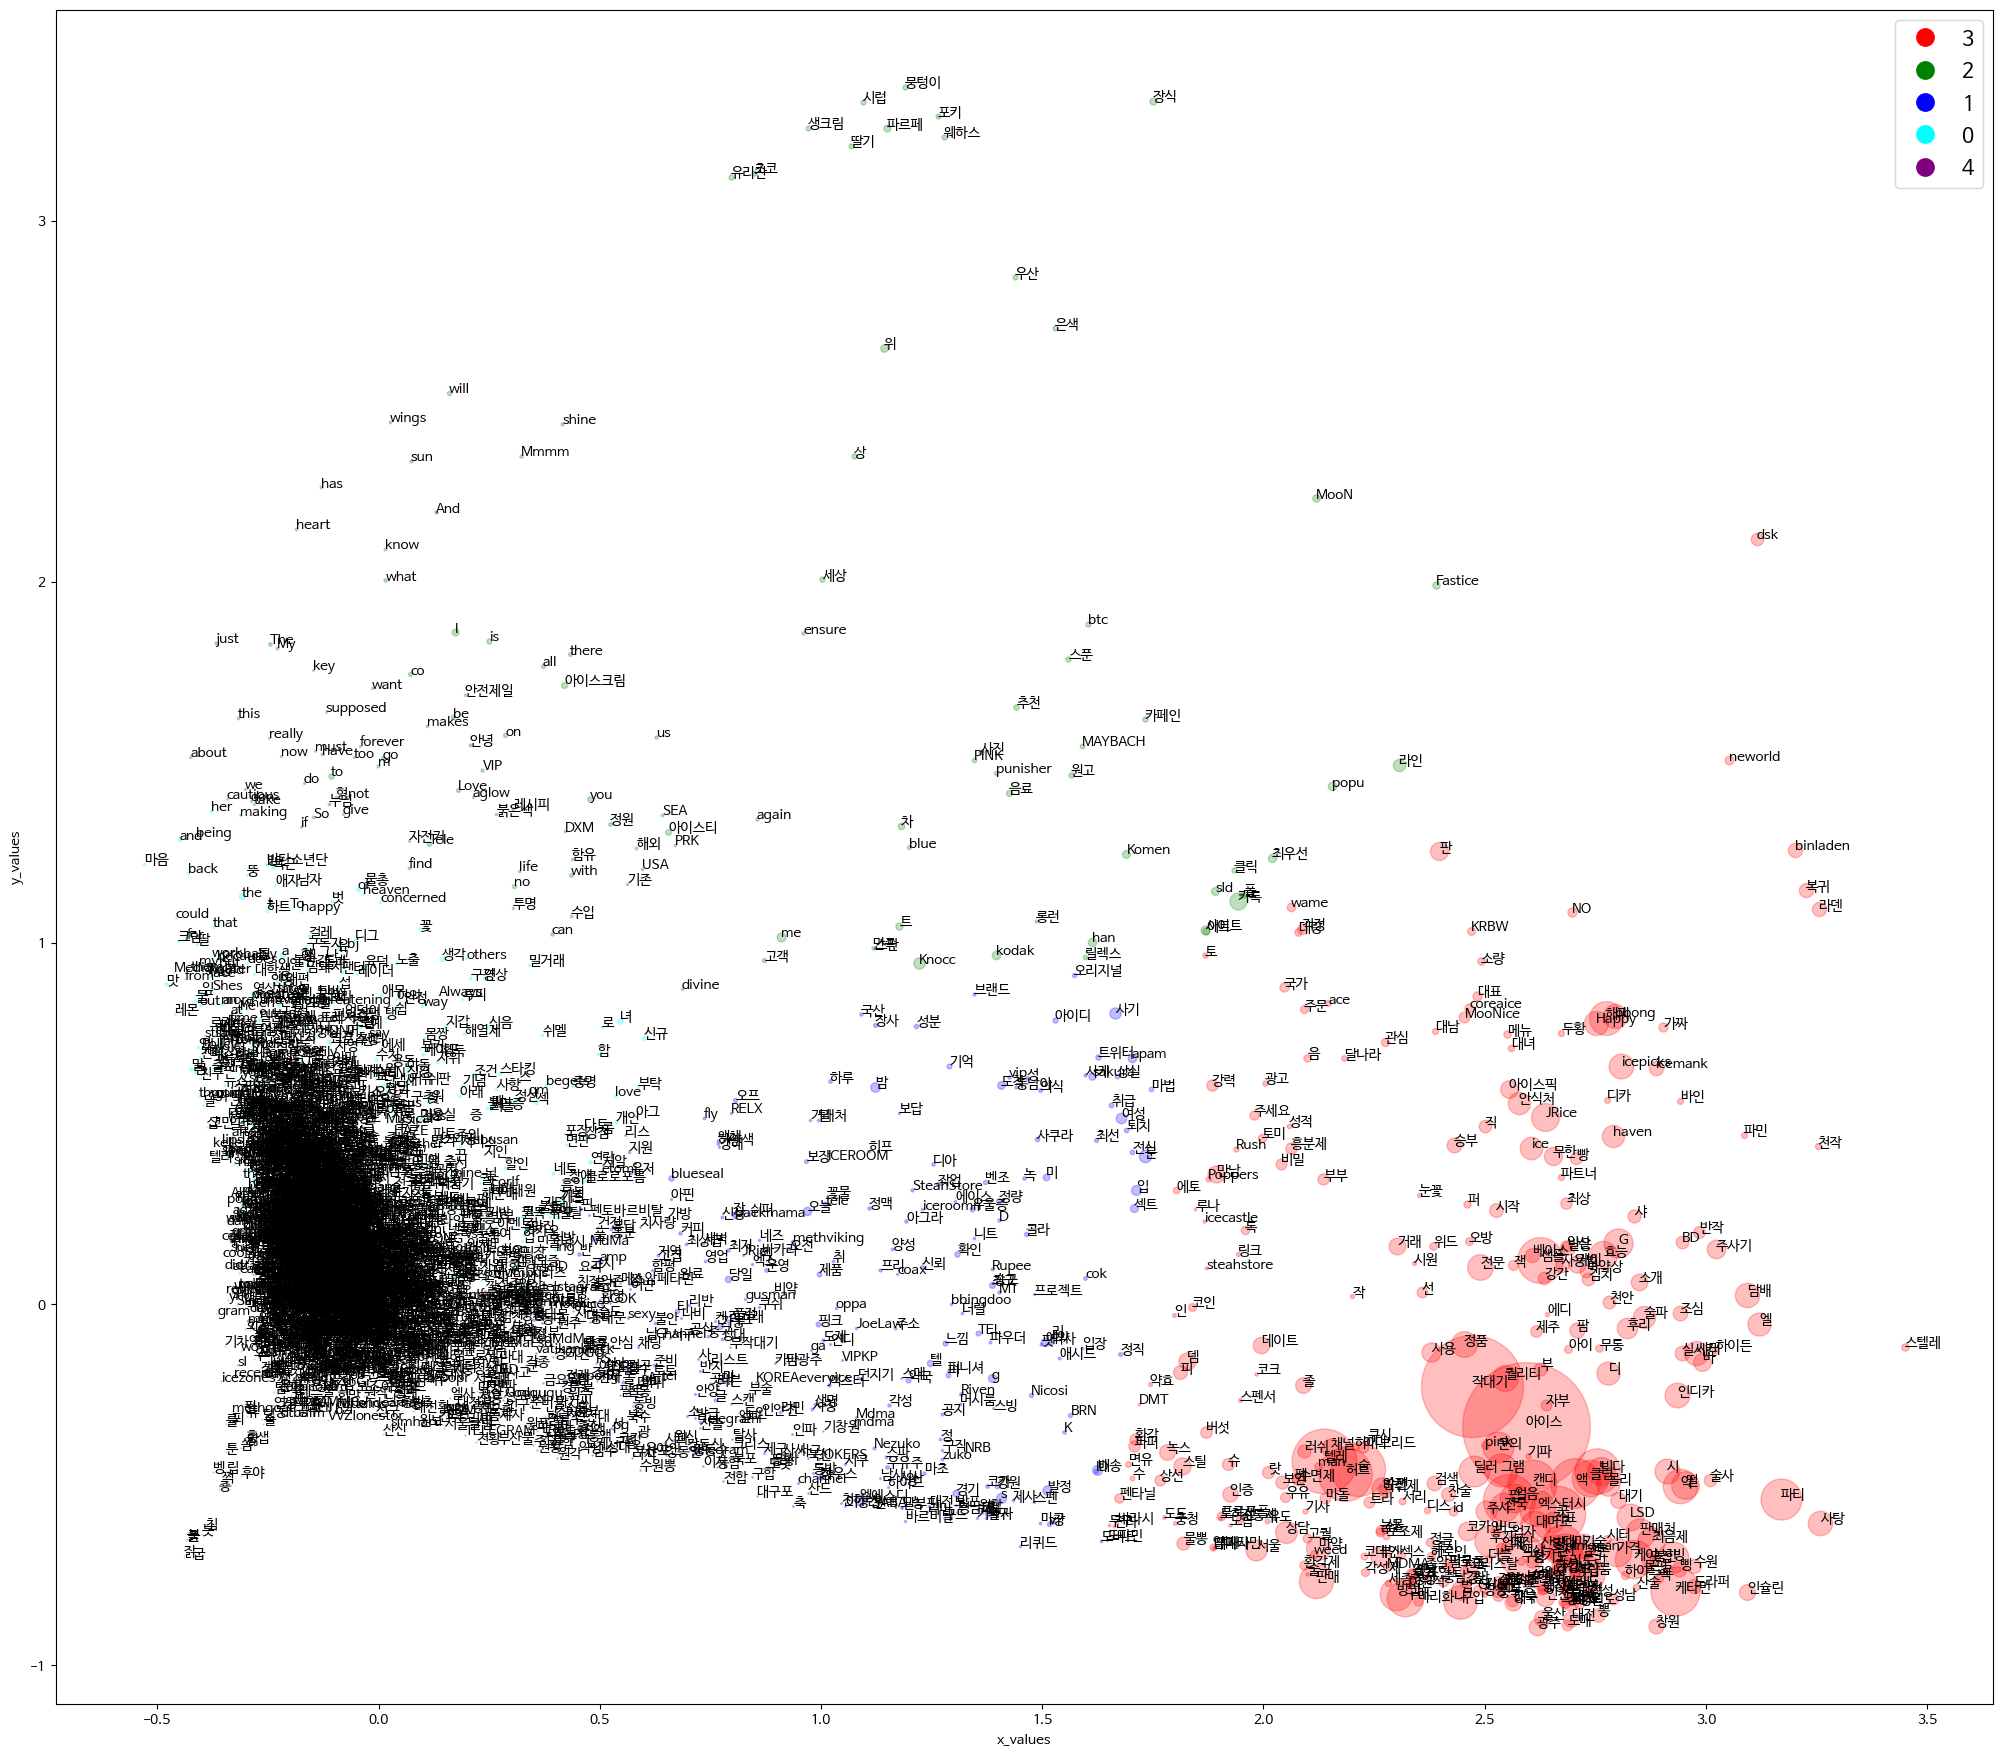

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet[PCA_data_complet['counts'] >= 2].labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet[PCA_data_complet['counts'] >= 2].iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet[PCA_data_complet['counts'] >= 2].x_values[i], PCA_data_complet[PCA_data_complet['counts'] >= 2].y_values[i], s=PCA_data_complet[PCA_data_complet['counts'] >= 2].counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet[PCA_data_complet['counts'] >= 2].iterrows()]
plt.show()

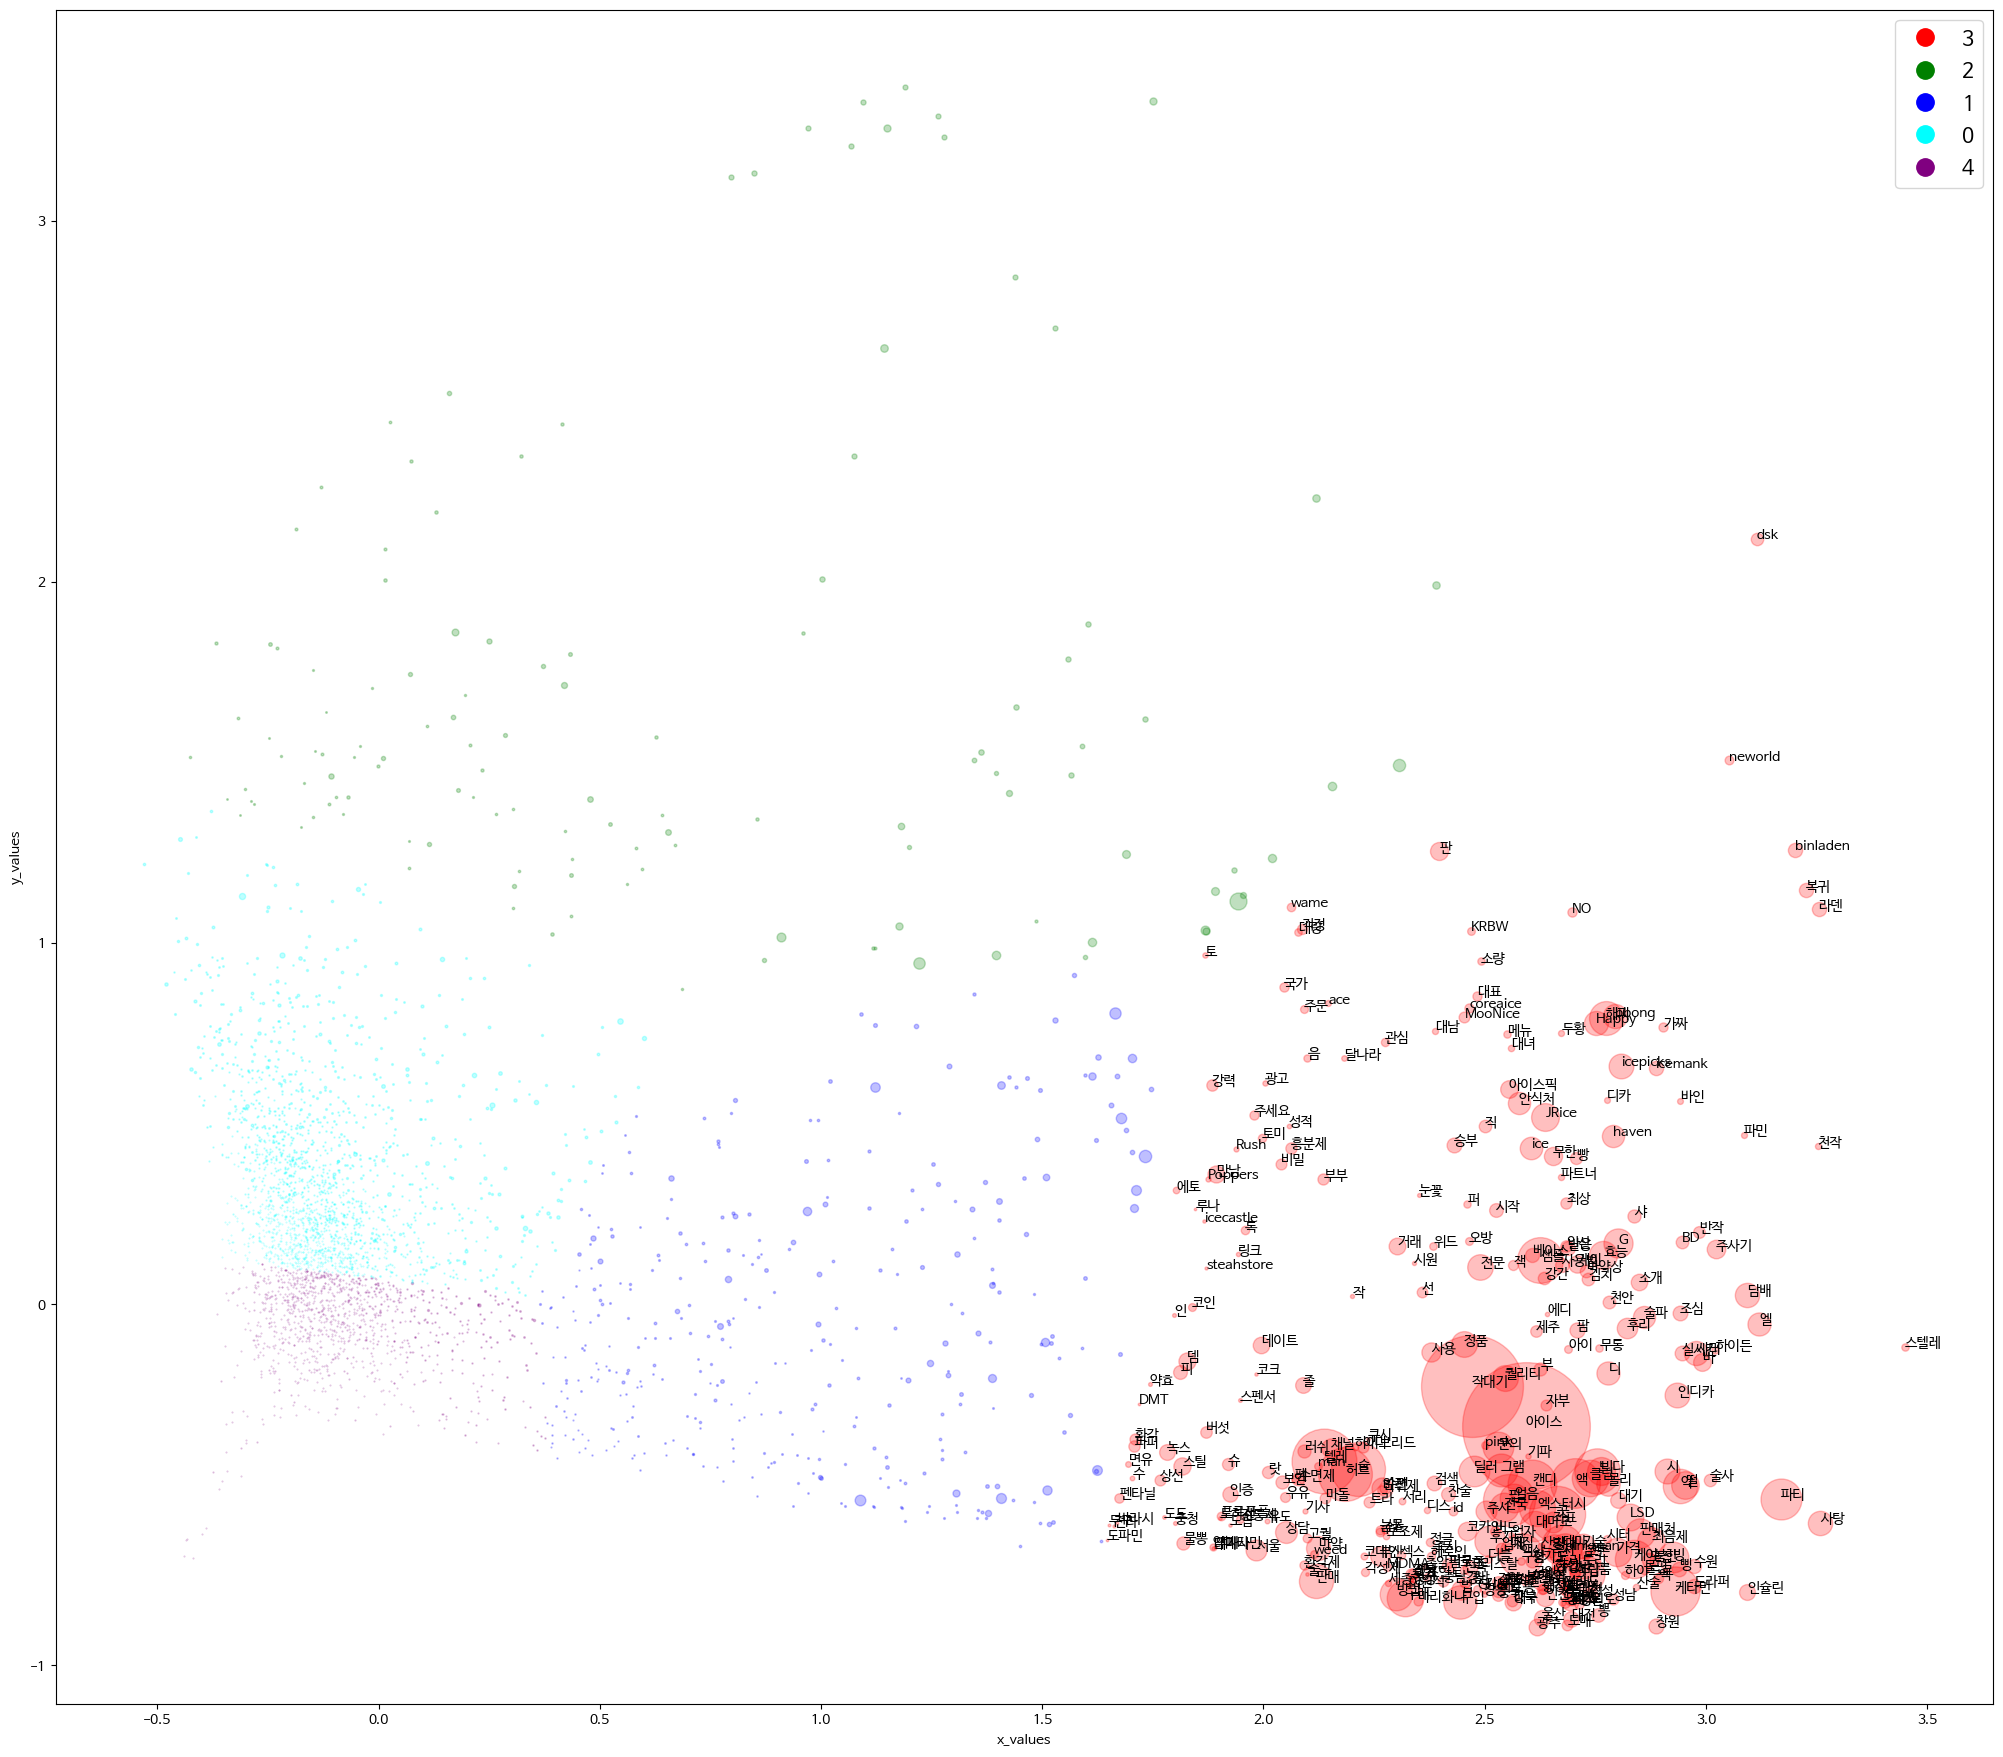

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet[PCA_data_complet['counts'] >= 2].labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet[PCA_data_complet['counts'] >= 2].iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet[PCA_data_complet['counts'] >= 2].x_values[i], PCA_data_complet[PCA_data_complet['counts'] >= 2].y_values[i], s=PCA_data_complet[PCA_data_complet['counts'] >= 2].counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet[PCA_data_complet['counts'] >= 2].iterrows() if row.labels == PCA_data_complet[PCA_data_complet['counts'] >= 2].labels[0]]
plt.show()